## Import Spark

In [1]:
import os
# os.environ["SPARK_HOME"]
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.1
      /_/

Using Python version 3.6.5 (default, Mar 29 2018 13:14:23)
SparkSession available as 'spark'.


In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

## Load data into Spark DataFrame

In [3]:
from pyspark import SparkContext
import pyspark.sql.functions as F

In [4]:
# df is A Spark DataFrame
df = spark.read.csv('../data/event_ds.csv',header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [5]:
# show the first 20 rows of the Spark DataFrame
df.show()

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168535490|    P| 6616004|2017-03-30|
|168551042|    P|  505355|2017-03-30|
|168540348|    P|   77260|2017-03-30|
|168530895|    P|       0|2017-03-30|
|168530479|    P| 1676759|2017-03-30|
|168551607|    P| 5517668|2017-03-30|
|168548101|    P| 6913185|2017-03-30|
|168542680|    P|       0|2017-03-30|
|168550237|    P| 6511070|2017-03-30|
|168519439|    P|       0|2017-03-30|
|168548942|    P| 4112522|2017-03-30|
|168551495|    P|22797719|2017-03-30|
|168551383|    P| 7149583|2017-03-30|
|168550382|    P| 3971726|2017-03-30|
|168548945|    P|20429929|2017-03-30|
|168550086|    P| 7172624|2017-03-30|
|168540348|    P| 6437996|2017-03-30|
|168551522|    P|  150918|2017-03-30|
|168541857|    P|  295529|2017-03-30|
|168546393|    P|  242615|2017-03-30|
+---------+-----+--------+----------+
only showing top 20 rows



---
## Data Exploration

### Features Type Casting and Verification

In [6]:
# create new or overwrite original field with withColumn: 
# for "date" column, convert "string" type to "date" type 
# for "id" column, convert "string" type to "int" type
df = df.withColumn('date', F.col('date').cast('date'))
for col in ['uid', 'song_id']:
    df = df.withColumn(col, F.col(col).cast('int'))
df

DataFrame[uid: int, event: string, song_id: int, date: date]

Note that song_id has a **special** negative value and there are missing values in __event__ column

In [7]:
# show the descriptive statistics of the DataFrame
df.describe().show()

+-------+--------------------+-------+-----------------+
|summary|                 uid|  event|          song_id|
+-------+--------------------+-------+-----------------+
|  count|             2194568|2194568|          2049856|
|   mean|1.6645771046223176E8|   null| 5915507.37680842|
| stddev|1.6287908907350207E7|   null|6653398.679705742|
|    min|             2626270|      D|               -1|
|    max|           168941043|      S|         24024145|
+-------+--------------------+-------+-----------------+



### Missing Values
Only Nulls in **song_id** feature.

In [8]:
# Count the number of Nulls in every feature
df.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+-----+-------+----+
|uid|event|song_id|date|
+---+-----+-------+----+
|  0|    0| 144712|   0|
+---+-----+-------+----+



In [9]:
# Check the data with missing values
df.filter(F.col('song_id').isNull()).show(10)

+---------+-----+-------+----------+
|      uid|event|song_id|      date|
+---------+-----+-------+----------+
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
+---------+-----+-------+----------+
only showing top 10 rows



#### Nulls Pattern Inspection
The song ids of the "search" event are all missing. A tiny proportion of the "play" event song ids is missing. None of song ids is absent in "download" event. 

In [10]:
# group by aggregation
df.groupBy('event').count().show()
df.filter(F.col('song_id').isNull()).groupBy('event').count().show()

+-----+-------+
|event|  count|
+-----+-------+
|    D| 119950|
|    S| 144337|
|    P|1930281|
+-----+-------+

+-----+------+
|event| count|
+-----+------+
|    S|144337|
|    P|   375|
+-----+------+



### Song ids and User ids

In [11]:
# simple count rows
df.count()

2194568

In [12]:
# count number of distinct user ids and song ids
df.select('uid').distinct().count(), df.select('song_id').distinct().count()

(9757, 157320)

In [13]:
df.select('uid', 'song_id').distinct().count()

597572

### Date

In [14]:
df.select(F.min(F.col('date')).alias('start_date'), F.max(F.col('date')).alias('end_date')).show()

+----------+----------+
|start_date|  end_date|
+----------+----------+
|2017-03-30|2017-05-12|
+----------+----------+



In [15]:
date_count = df.groupBy('date').count().toPandas()

(array([736419., 736426., 736433., 736440., 736447., 736454., 736461.]),
 <a list of 7 Text xticklabel objects>)

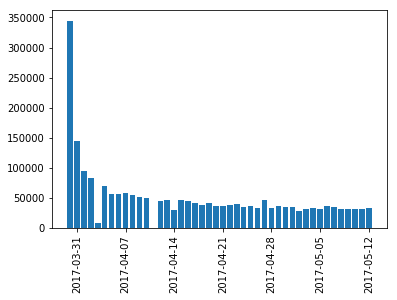

In [16]:
# We use matplotlib for plotting
import matplotlib.pyplot as plt
# This statement allow to display plot without asking to
%matplotlib inline
plt.bar(date_count.date.tolist(), date_count['count'])
plt.xticks(rotation='vertical')

---
---
## Generation of Implicit Rating

### Frequecy 

In [17]:
import datetime
from dateutil import parser

reco_window_size= 44 
reco_window_end_date = parser.parse('2017-05-12').date()
reco_window_start_date = reco_window_end_date - datetime.timedelta(reco_window_size - 1)
print('recommendation window:', reco_window_start_date, '~', 
      reco_window_end_date, '\ndays:', reco_window_size)

recommendation window: 2017-03-30 ~ 2017-05-12 
days: 44


In [18]:
def frequency_reco_generation_time_windows(df,event,time_window_list,snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid', 'song_id') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date),1).otherwise(0))\
               .alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [19]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D']
time_window_list = [1,3,7,14,30,44]
snapshot_date = reco_window_end_date

df_reco_list = []
for event in event_list:
    df_reco_list.append(frequency_reco_generation_time_windows(df,event,
                                                                     time_window_list,snapshot_date))

In [20]:
df_reco_list[0].show()

+---------+--------+-------------+-------------+-------------+--------------+--------------+--------------+
|      uid| song_id|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_P_last_44|
+---------+--------+-------------+-------------+-------------+--------------+--------------+--------------+
|168548942| 4589801|            0|            0|            0|             0|             0|             1|
|168542101|  849435|            0|            0|            0|             0|             0|             1|
|168551694|23489729|            0|            0|            0|             0|             0|             1|
|168551694| 1222356|            0|            0|            0|             0|             0|             1|
|168552867| 1094256|            0|            0|            0|             0|             0|             1|
|168536197| 6762377|            0|            0|            0|             0|             0|             4|
|168553253|  891952|        

### Recency

In [21]:
from datetime import timedelta
def recency_reco_generation_time_windows(df,event,snapshot_date):
    """
    generate recency features for one event type, so totally 3 possible features
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid', 'song_id') \
        .agg(F.datediff(F.lit(snapshot_date), F.max(F.col('date'))).alias('rec_' + event) 
            ) 
    
    return df_feature

In [22]:
event_list = ['P','D']
snapshot_date = reco_window_end_date

for event in event_list:
    df_reco_list.append(recency_reco_generation_time_windows(df,event,
                                                                     snapshot_date))
df_reco_list

[DataFrame[uid: int, song_id: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint, freq_P_last_44: bigint],
 DataFrame[uid: int, song_id: int, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint, freq_D_last_44: bigint],
 DataFrame[uid: int, song_id: int, rec_P: int],
 DataFrame[uid: int, song_id: int, rec_D: int]]

---
### Play/Song Length

In [23]:
df_play = spark.read.csv('../data/play_ds.csv',header=True)
df_play.show(10)

+---------+------+-------+----------+---------+-----------+
|      uid|device|song_id|      date|play_time|song_length|
+---------+------+-------+----------+---------+-----------+
|168535490|    ar|6616004|2017-03-30|      283|        283|
|168551042|    ar| 505355|2017-03-30|      106|        277|
|168540348|    ar|  77260|2017-03-30|    64528|          0|
|168530895|    ar|      0|2017-03-30|      264|        265|
|168530479|    ar|1676759|2017-03-30|      338|        338|
|168551607|    ar|5517668|2017-03-30|      231|        245|
|168548101|    ip|6913185|2017-03-30|       40|        198|
|168542680|    ar|      0|2017-03-30|      284|        285|
|168550237|    ar|6511070|2017-03-30|      144|        237|
|168519439|    ar|      0|2017-03-30|      227|        228|
+---------+------+-------+----------+---------+-----------+
only showing top 10 rows



In [24]:
# df_play_feature_window.show(10)
df_profile = df_play.drop('device').distinct() \
    .withColumn('uid', F.col('uid').cast('int')) \
    .withColumn('song_id', F.col('song_id').cast('int')) \
    .withColumn('play_time', F.col('play_time').cast("float")) \
    .withColumn('song_length', F.col('song_length').cast('float'))

#### Play Time and Song Length Cleansing

In [25]:
df_profile = df_profile.filter((F.col('play_time') >= 0) & (F.col('song_length') >= 0) \
                              & (F.col('play_time') <= F.col('song_length')))
# df_profile.describe().show()
df_profile.show(10)

+---------+--------+----------+---------+-----------+
|      uid| song_id|      date|play_time|song_length|
+---------+--------+----------+---------+-----------+
|168550004|       0|2017-03-30|      0.0|      180.0|
|168530027|  461314|2017-03-30|    277.0|      277.0|
|168548945|20274234|2017-03-30|      1.0|      307.0|
|168553584| 7149583|2017-03-30|    214.0|      215.0|
|168553426|   64840|2017-03-30|     27.0|      273.0|
|168551535|22873373|2017-03-30|      0.0|        0.0|
|168550549|11592276|2017-03-30|      1.0|      285.0|
|168543638| 3338912|2017-03-30|      0.0|       29.0|
|168548514|  145454|2017-03-30|      3.0|      324.0|
|168553532| 4078943|2017-03-30|     22.0|      283.0|
+---------+--------+----------+---------+-----------+
only showing top 10 rows



In [26]:
# feature: play_time/song_length
def relative_freq_reco_generation_time_windows(df,time_window_list,snapshot_date):
    """
    generate counts of songs play 80% of their song length (using play_ds data) for different time window
    """
    df_feature = df \
        .groupBy('uid', 'song_id') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date) \
                            & (F.col('play_time')/F.col('song_length')>=0.8),1).otherwise(0))\
               .alias('rela_freq_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [27]:
time_window_list = [1,3,7,14,30,44]
snapshot_date = reco_window_end_date
df_rela_freq_reco = relative_freq_reco_generation_time_windows(df_profile, time_window_list, snapshot_date)
df_rela_freq_reco

DataFrame[uid: int, song_id: int, rela_freq_last_1: bigint, rela_freq_last_3: bigint, rela_freq_last_7: bigint, rela_freq_last_14: bigint, rela_freq_last_30: bigint, rela_freq_last_44: bigint]

---
### Join all feature datasets together

In [28]:
def join_reco_data(df_reco_list):
    df_master = df_reco_list[0]
    df_reco_list.pop(0)
    for df_reco in df_reco_list:
        df_master = df_master.join(df_reco,on=['uid','song_id'],how='left')
        #df_master.persist() # uncomment if number of joins is too many
    return df_master    

In [32]:
df_reco_list_copy = df_reco_list.copy()
df_reco_list_copy.append(df_rela_freq_reco)
df_reco_final = join_reco_data(df_reco_list_copy)
df_reco_final

DataFrame[uid: int, song_id: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint, freq_P_last_44: bigint, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint, freq_D_last_44: bigint, rec_P: int, rec_D: int, rela_freq_last_1: bigint, rela_freq_last_3: bigint, rela_freq_last_7: bigint, rela_freq_last_14: bigint, rela_freq_last_30: bigint, rela_freq_last_44: bigint]

In [33]:
df_reco_final.fillna(0).toPandas().to_csv('../data/df_reco_final.csv',index=False)